In [0]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

В рамках этого скрипта производится подготовка данных для дальнейшей работы. 
Преобразование данных в признаки происходит уже в других скриптах.

In [0]:
DATA_DIR = './drive/My Drive/Colab Notebooks/VK_internship/ThirtyMusic/'
SAVE_DIR = './drive/My Drive/Colab Notebooks/VK_internship/'

In [0]:
# Чтение датафрейма из файла
# Из датафрейма не берутся столбцы, содержащие только одно уникальное значение 
# Избыточные столбцы формируются в силу специфики выбора метода парсинга файла
persons_df = pd.read_csv(DATA_DIR+'entities/persons.idomaar', header=None, sep = '\t',
                      usecols = [1,3], names = ['person_id','transaction_info'])
# Формат столбцов: первый столбец содержит идентификатор исполнителя (person), 
# другой столбец содержит словари транзакций
# Далее надо развернуть словарь в отдельные столбцы, соответствующие полям,
# при этом учитывая, что в данных есть пропуски
persons_df = persons_df.replace(regex=[":,", ":null,"], value = ":\"\",")
persons_df = pd.concat(
    [persons_df['person_id'],
     persons_df['transaction_info'].apply(lambda x: pd.Series(eval(x)))], 
     axis = 1)
persons_df = persons_df.drop(columns = ["MBID"])
# теперь датафрейм содержит идентификатор исполнителя и его имя/название
# этот датафрейм для того, чтобы понять, какой исполнитель скрывается под идентификатором
persons_df.to_csv(SAVE_DIR+"artists_names_and_id.csv", index = False)
del persons_df

**Tracks**

In [0]:
# Чтение информации о композициях
# Операции занимают много памяти, поэтому выполняются по батчам
with open(SAVE_DIR+"tmp_tracks_and_artists.csv", "w") as tmp_file:
  for tracks_df in pd.read_csv(DATA_DIR+'entities/tracks.idomaar', 
                              header=None, sep = '\t',
                              usecols = [1,3,4], 
                              names = ['track_id',
                                       'transaction_info_1',
                                       'transaction_info_2'], 
                              chunksize=10000):      
    tracks_df = tracks_df.replace(regex=[":,", "null"], value = [":\"\",", "\" \""])
    tracks_df = pd.concat(
        [tracks_df['track_id'],
        tracks_df['transaction_info_1'].apply(lambda x: pd.Series(eval(x))),
        tracks_df['transaction_info_2'].apply(lambda x: pd.Series(eval(x)))], 
        axis = 1)
    tracks_df: pd.DataFrame(columns = ["track_id", "artists", "tags", "playcount"]) = \
        tracks_df.drop(columns=["duration", "MBID", "name", "albums"])
    tracks_df["artists"] = tracks_df["artists"].apply(lambda x: x[0]["id"])
    tracks_df.to_csv(tmp_file, index = False)

# По идее название песни может быть полезно после обработки средствами NLP, 
# но в данной задаче я думаю, что затраты на вычисления необходимых признаков  
# могут превышать выгоду от их использования.
# Поэтому в этом датафрейме были выделены лишь следующие признаки:
# идентификатор композиции, количество проигрываний композиции,
# идентификатор исполнителя, идентификаторы тэгов

In [0]:
tracks_df = pd.read_csv(SAVE_DIR+"tmp_tracks_and_artists.csv")

In [0]:
# В качестве рейтинга исполнителя в будущем я планирую использовать общее количество прослушиваний
# Поэтому для исполнителей формируются ранги и записываются в файл: 
# они понадобяться уже в финале для валидации, о чем речь будет позже

artist_rankings = tracks_df.loc[:,["playcount", "artists"]].groupby("artists").sum()
artist_rankings.to_csv(SAVE_DIR+"artists_ranks.csv")
del artist_rankings
tracks_df = tracks_df.drop(columns=["playcount"])

In [0]:
# Теги исполнителей тоже кладу в отдельный файл, чтобы не занимать много памяти:
artists_tags = tracks_df.groupby("artists")["tags"].apply(lambda x: np.unique(list(itertools.chain.from_iterable(x))))
artists_tags.to_csv(SAVE_DIR+"artists_tags.csv")
del artists_tags
tracks_df = tracks_df.drop(columns=["tags"])

In [0]:
# Теперь tracks_df по факту датафрейм, представляющий словарь треков и исполнителей
tracks_df.to_csv(SAVE_DIR+"tracks_and_artists.csv", index = False)

**Sessions**

In [0]:
counter = 0
with open(SAVE_DIR+"tmp_sessions_df.csv", "w") as tmp_file:
  for sessions_df in pd.read_csv(DATA_DIR+'relations/sessions.idomaar', 
                                 header=None, sep = '\t',
                                 usecols = [3], names = ['transaction_info'], 
                                 chunksize = 10000):
    sessions_df = sessions_df.replace(regex=[":,", "null"], value = [":\"\",", "\"\""])
    sessions_df = sessions_df['transaction_info'].apply(
        lambda x: pd.Series(eval("{" + x.split("} {")[-1]))
        )
    sessions_df["subjects"] = sessions_df["subjects"].apply(lambda x: x[0]["id"])
    sessions_df = sessions_df.rename(columns={"subjects":"user_id"})
    sessions_df = sessions_df.explode("objects")
    sessions_df = pd.concat([sessions_df["user_id"], 
                            sessions_df["objects"].apply(lambda x: pd.Series({
                                "track_id": x["id"],
                                "playtime": x["playtime"]
                                }))], axis = 1)
    sessions_df.to_csv(tmp_file, index = False)
    counter+=1
    print(counter)

In [0]:
sessions_df = pd.read_csv(SAVE_DIR+"tmp_sessions_df.csv")

In [0]:
sessions_df = sessions_df.loc[sessions_df["playtime"]!="playtime"] 
# при выполнении цикла, я допустила ошибку и названия столбцов были записаны в датафрейм как новые строки

In [0]:
bins = range(-10,240,10)
np.histogram(sessions_df["playtime"].astype(int), bins=bins)

(array([2908889, 1440554,   79948,   61370,  181911,  135859,  142034,
         158513,  165103,  179530,  222010,  250234,  297737,  381357,
         447877,  541631,  637802,  766020,  909287, 1117243, 1265550,
        1434670, 1581258, 1726717]),
 array([-10,   0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110,
        120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]))

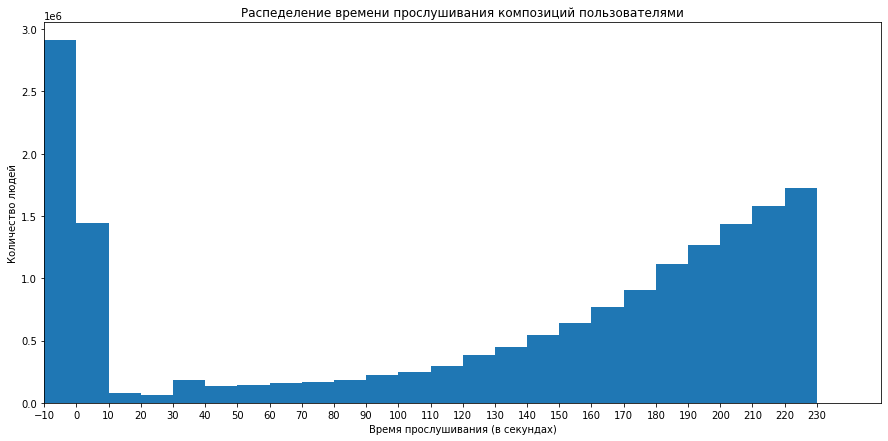

In [0]:
plt.figure(figsize=(15,7))
plt.hist(sessions_df["playtime"].astype(int), bins=bins)

plt.title("Распеделение времени прослушивания композиций пользователями")
plt.xticks(bins)
plt.xlim(-10,250)
plt.ylabel("Количество людей")
plt.xlabel("Время прослушивания (в секундах)")
plt.show()

График нужен, чтобы понять, слушал ли пользователь композицию или нет.
Судя по всему, чаще всего люди, если не хотят слушать песню, 
переходят к следующей композиции не дольше, чем через 10 секунд.
Начиная от 40 секунд наблюдается постепенный рост прослушивания композиций людьми.
Я предполагаю, что на интервале до 40 секунд, люди скорее всего перематывают песни,
которые не хотят слушать в данный момент или которые им не понравились.
Это предположение связано с тем, что на интервали от 30 до 40 секунд наблюдается ступенька.
(На графике из-за масштаба не так заметно, что разница между интервалами 30-40 и 40-50 составляет 
 порядка 50 тысяч прослушиваний, что является довольно-таки большим значением).
-1 - значение времени проигрывания композиций, которые не были прослушаны вовсе.

In [0]:
sessions_df = sessions_df.astype(int)
sessions_df = sessions_df.loc[sessions_df["playtime"]>40] 
# На основании графика, в обучение будут включены только те композиции,
# которые были прослушаны не менее, чем в течении 40 секунд, 
# так как скорее всего при прослушивании не менее, чем в течении 40 секунд
# пользователь слушал песню, а не пролистал.
# В датафрейме три стобца: идентификатор пользователя, идентификатор композиции, время проигрывания

In [0]:
tracks_df["track_id"] = tracks_df["track_id"].astype(int)
sessions_df = sessions_df.merge(tracks_df, on="track_id", how = "inner")
sessions_df = sessions_df.drop(columns = ["track_id"])
 
# ранг исполнителя для пользователя, будет измеряться как время прослушивания:
# пока не решила, как буду использовать это
sessions_df = sessions_df.groupby(["user_id", "artists"]).sum().reset_index()

sessions_df.to_csv(SAVE_DIR+"users_artists.csv")
del sessions_df

Информация из других наборов данных.

**Playlists**

На мой взгляд наличие исполнителей в одном плейлисте может говорить о том, 
что артисты похожи, из предположения, что по большей части
плейлисты формируются из относительно похожих композиций 
по жанру и вкусовых предпочтений пользователя

In [0]:
playlists_df = pd.read_csv(DATA_DIR+'entities/playlist.idomaar', header=None, sep = '\t', 
                           usecols = [1, 4], names = ["playlist_id","track_id"])
playlists_df["track_id"] = playlists_df["track_id"].apply(lambda x: eval(x)["objects"])
playlists_df = playlists_df.explode("track_id")

In [0]:
playlists_df = playlists_df[playlists_df.astype(str)["track_id"] != '[]']

In [0]:
playlists_df = playlists_df.dropna()

In [0]:
playlists_df["track_id"] = playlists_df["track_id"].apply(lambda x: x["id"] if "id" in x else -1)

In [0]:
# Теперь заменяем треки исполнителями, удаляем дубликаты и пишем в файл
# В результате получится бинарный признак присутствия исполнителя в конкретном плейлисте
playlists_df = playlists_df.merge(tracks_df, on="track_id", how = "inner")
playlists_df = playlists_df.drop(columns = ["track_id"]).drop_duplicates()
playlists_df.to_csv(SAVE_DIR+"artists_in_playlists.csv", index = False)
del playlists_df

**Love**

In [0]:
counter = 0
with open(SAVE_DIR+"tmp_love_info.csv", "w") as tmp_file:
  for love_df in pd.read_csv(DATA_DIR+'relations/love.idomaar', header=None, sep = '\t', 
                            usecols = [2], names = ["info"], chunksize=10000):
    love_df = love_df["info"].apply(lambda x: pd.Series(
        { "user_id": eval(x[x.find("{",5)-1:])["subjects"][0]["id"],
        "track_id": eval(x[x.find("{",5)-1:])["objects"][0]["id"]}
        ))
    love_df.to_csv(tmp_file, index = False, header=False)
    counter+=1
    print(counter)

In [0]:
love_df = pd.read_csv(SAVE_DIR+"tmp_love_info.csv", 
                      header = None, 
                      names = ["user_id", "track_id"])


In [0]:
tracks_df = pd.read_csv(SAVE_DIR+"tracks_and_artists.csv", usecols = [0,2])

In [0]:
love_df = love_df.merge(tracks_df, on="track_id", how = "inner")

love_df = love_df.groupby(["user_id","artists"]).count().reset_index()
love_df = love_df.rename(columns = {"track_id":"likes_amount"})
love_df.to_csv(SAVE_DIR+"artists_user_likes.csv", index = False)
del love_df